In [20]:
import pandas as pd
import numpy as np
from openff.toolkit.topology import Molecule
from openff.units import unit
import seaborn as sb
from scipy import stats
import matplotlib.pyplot as plt
from rdkit.Chem import Draw
from chargecraft.storage.storage import MoleculePropStore
from naglmbis.models import load_charge_model

AU_ESP = unit.atomic_unit_of_energy / unit.elementary_charge


def equalityline(x, y, ax = None, **kwargs):
    x0, x1 = min(x), max(x)
    y0, y1 = min(y), max(y)
    lims = [min(x0, y0), max(x1, y1)]
    ax = ax or plt.gca()
    ax.plot(lims, lims, **kwargs)

def m(x, y, ax = None, **kwargs):
    
    x = np.array(x)
    y = np.array(y)
    ax = ax or plt.gca()
    m =(np.sum((x - y)**2, axis=0)/(y.shape[0]))**0.5
    ax.annotate(f'$RMSE= {float(m):.2f}$',
                xy=(.01, .99), xycoords=ax.transAxes, fontsize=8,
                color='darkred', backgroundcolor='#FFFFFF99', ha='left', va='top')   
    
def kde(x, y, ax = None, **kwargs):
    if isinstance(x, np.ndarray) and isinstance(y, np.ndarray):
        x = np.array(x)
        y = np.array(y)
    ax = ax or plt.gca()
    kernel = stats.gaussian_kde(x)(y)
    ax.scatter(x, y, c=kernel, s=5)
    
def calculate_esp_monopole_au(
    grid_coordinates: unit.Quantity,  # N x 3
    atom_coordinates: unit.Quantity,  # M x 3
    charges: unit.Quantity,  # M
    ):
    """Generate the esp from the on atom monopole
    
    Parameters
    ----------
    grid_coordinates: unit.Quantity
        grid on which to build the esp on 

    atom_coordinates: unit.Quantity
        coordinates of atoms to build the esp  
    
    charges: unit.Quantity
        monopole or charges

    Returns
    -------
    monopole_esp: unit.Quantity
        monopole esp
    """
    #prefactor  
    ke = 1 / (4 * np.pi * unit.epsilon_0) # 1/vacuum_permittivity, 1/(e**2 * a0 *Eh)

    if isinstance(charges, unit.Quantity):
       charges = charges.flatten()
    else:
        charges = np.array(charges).flatten() * unit.e
    #Ensure everything is in AU and correct dimensions
    grid_coordinates = grid_coordinates.reshape((-1, 3)).to(unit.bohr)  #Å to Bohr
    atom_coordinates = atom_coordinates.reshape((-1, 3)).to(unit.bohr)    #Å to Bohr
    #displacement and distance
    displacement = grid_coordinates[:, None, :] - atom_coordinates[None, :, :]  # N x M x 3 B
    distance = np.linalg.norm(displacement.m, axis=-1)*unit.bohr # N, M
    inv_distance = 1 / distance  #N, M

    esp = ke*np.sum(inv_distance * charges[None,:], axis=1)  # (N,M)*(1,M) -> (N,M) numpy broadcasts all charges. Over all atoms  =  Sum over M (atoms), resulting shape: (N,) charges broadcast over each N
    
    return esp.to(AU_ESP)
    
charge_model_esp= 'nagl-gas-charge-dipole-esp-wb-default'
charge_model_charge = "nagl-gas-charge-wb"
charge_model_dipole =  "nagl-gas-charge-dipole-wb"

gas_charge_model = load_charge_model(charge_model=charge_model_charge)
gas_charge_dipole_model = load_charge_model(charge_model=charge_model_dipole)
gas_charge_dipole_esp_model = load_charge_model(charge_model_esp)

models = {
    "charge_model": gas_charge_model,
    "dipole_model": gas_charge_dipole_model,
    "esp_model": gas_charge_dipole_esp_model,
}


In [33]:
parquet = "/mnt/storage/nobackup/nca121/paper_charge_comparisons/async_chargecraft_more_workers/conformer_test/charge_models_no_riniker_2.parquet"
df = pd.read_parquet(parquet)
df

,mbis_charges,am1bcc_charges,espaloma_charges,riniker_monopoles,resp_charges,qm_dipoles,mbis_dipoles,am1bcc_dipole,espaloma_dipole,riniker_dipoles,...,mbis_esp,riniker_esp_rms,riniker_esp,qm_esp,molecule,grid,geometry,conformer_no,smiles,energy
0,"[-0.4049628140674173, 0.14432636053253614, 0.1...","[-0.0288000606060606, -0.18090006060606062, 0....","[-0.12456212802366777, 0.055501231415705246, 0...",None,"[-0.706, 0.2087, 0.1506, -0.3581, -0.0413, -0....",4.730896,4.856963,4.670946,6.269484,NaN,...,"[0.018815215526470988, 0.018345010783864992, 0...",NaN,NaN,"[0.018448609456786613, 0.01820817830002497, 0....",[C:1]([C:2]1=[C:3]([C:7]([S:8][C:9]([C:10]([N:...,"[[-8.13172798348494, -0.7071067813469041, -0.2...","[-5.018616314203731, 0.4632425171600322, 0.100...",5,[H][C]1=[N][C]([C]([H])([H])[S][C]([H])([H])[C...,-1112.350159
1,"[-0.4037704770262108, 0.14156304512088946, 0.1...","[-0.03264854545454547, -0.17574854545454546, 0...","[-0.12456212802366777, 0.055501231415705246, 0...",None,"[-0.3724, 0.156, 0.268, -0.536, 0.123, -0.416,...",4.226850,4.326920,4.186477,7.197369,NaN,...,"[-0.04516719393616425, -0.04482597858014744, -...",NaN,NaN,"[-0.04206013809254472, -0.041903892848132784, ...",[C:1]([C:2]1=[C:3]([C:7]([S:8][C:9]([C:10]([N:...,"[[-8.838834764831843, -1.7677669529663687, -2....","[4.484300138243575, 0.35318331849637646, -1.28...",3,[H][C]1=[N][C]([C]([H])([H])[S][C]([H])([H])[C...,-1112.351913
2,"[-0.40505937617927246, 0.14217284107975822, 0....","[-0.03586060606060607, -0.17896060606060607, 0...","[-0.12456212802366777, 0.055501231415705246, 0...",None,"[-0.4323, 0.2093, 0.1895, -0.5538, 0.1625, -0....",3.577225,3.826449,3.734178,6.274385,NaN,...,"[0.030029996676327022, 0.022934726808625225, 0...",NaN,NaN,"[0.030853001105334954, 0.02325668785908519, 0....",[C:1]([C:2]1=[C:3]([C:7]([S:8][C:9]([C:10]([N:...,"[[-8.8388347649922, -0.7071067816676175, 0.105...","[-4.3428902773538, 0.32350710654565373, 1.5659...",1,[H][C]1=[N][C]([C]([H])([H])[S][C]([H])([H])[C...,-1112.349073
3,"[-0.4094433697455668, 0.1478973259577606, 0.15...","[-0.0288303333333333, -0.1779303333333333, 0.2...","[-0.12456212802366777, 0.055501231415705246, 0...",None,"[-0.6885, 0.2564, 0.1417, -0.4687, 0.0818, -0....",4.397994,4.498523,4.359614,6.541107,NaN,...,"[0.014302161016454784, 0.013676902607081265, 0...",NaN,NaN,"[0.014605143404105903, 0.014216900660915854, 0...",[C:1]([C:2]1=[C:3]([C:7]([S:8][C:9]([C:10]([N:...,"[[-7.778174592570952, -1.0606601716194646, -0....","[-4.3430294101006, -1.0839230894545173, -0.765...",2,[H][C]1=[N][C]([C]([H])([H])[S][C]([H])([H])[C...,-1112.351719
4,"[-0.4081850001105134, 0.14921126934025616, 0.1...","[-0.029860666666666678, -0.17696066666666668, ...","[-0.12456212802366777, 0.055501231415705246, 0...",None,"[-0.6375, 0.2134, 0.288, -0.5415, 0.1128, -0.4...",3.780919,3.859773,3.671967,6.493866,NaN,...,"[0.017789256276210256, 0.023219617504266127, 0...",NaN,NaN,"[0.018580753077895196, 0.0246329030342487, 0.0...",[C:1]([C:2]1=[C:3]([C:7]([S:8][C:9]([C:10]([N:...,"[[-7.778174593212378, -0.35355339091398713, -0...","[-4.146999114569908, -1.4707830953845562, 1.57...",6,[H][C]1=[N][C]([C]([H])([H])[S][C]([H])([H])[C...,-1112.352163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,"[-0.44000147988059796, 0.33859736523892947, -0...","[-0.05586498245614034, -0.01726498245614034, -...","[-0.10983872936483015, 0.27650585247759235, -0...",None,"[-0.5583, 0.342, -0.5662, 0.1224, 0.0993, -0.4...",3.654122,3.767507,4.061059,2.652702,NaN,...,"[0.09220103840683276, 0.09275196970520054, 0.0...",NaN,NaN,"[0.0934209650979767, 0.0938590895494702, 0.091...",[C:1]([C:2]1=[C:3]([H:32])[c:4]2[c:5]([c:7]([H...,"[[-7.778174592959183, -2.4748737339672395, -1....","[4.876269232336068, 3.997392225685083, 0.79979...",1,[H][C]1=[C]([C]([H])([H])[H])[N]([H])[c]2[c]([...,-1221.404013
351,"[-0.4383900310382283, 0.33852306771309265, -0....","[-0.04988252631578947, -0.043282526315789466, ...","[-0.109838729364

In [64]:
df.columns

Index(['mbis_charges', 'am1bcc_charges', 'espaloma_charges',
       'riniker_monopoles', 'resp_charges', 'qm_dipoles', 'mbis_dipoles',
       'am1bcc_dipole', 'espaloma_dipole', 'riniker_dipoles', 'resp_dipole',
       'am1bcc_esp_rms', 'am1bcc_esp', 'espaloma_esp_rms', 'espaloma_esp',
       'resp_esp_rms', 'resp_esp', 'mbis_esp_rms', 'mbis_esp',
       'riniker_esp_rms', 'riniker_esp', 'qm_esp', 'molecule', 'grid',
       'geometry', 'conformer_no', 'smiles', 'energy', 'charge_model_esp',
       'dipole_model_esp', 'esp_model_esp'],
      dtype='object')

In [ ]:
  
def apply_new_models(row):
    openff_mol = Molecule.from_mapped_smiles(row['molecule'], allow_undefined_stereo=True)
    conformer = row['geometry'] * unit.angstrom
    openff_mol.add_conformer(conformer.reshape(-1, 3))
    rdkit_mol = openff_mol.to_rdkit()
    grid = row['grid']
    grid = np.array([g for g in grid]).reshape(-1, 3)*unit.angstrom
    for model_name, model in models.items():
        charge = model.compute_properties(rdkit_mol)["mbis-charges"].detach().numpy().flatten()
        esp = calculate_esp_monopole_au(grid, conformer, charge)
        row[model_name+'_esp'] = esp.m
    return row

df = df.apply(apply_new_models, axis=1)


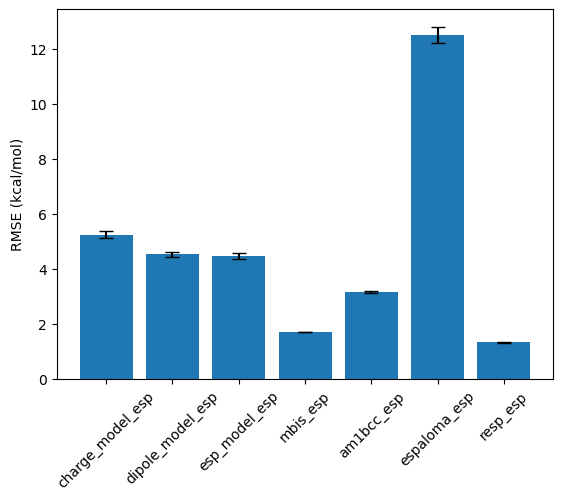

In [67]:
models = ['charge_model_esp', 'dipole_model_esp', 'esp_model_esp', 'mbis_esp', 'am1bcc_esp', 'espaloma_esp', 'resp_esp']
rmses = []
stdevs = []

AU_TO_KCAL = 627.5096080306

for model in models:
   differences = df['qm_esp'] - df[model]
   squared_differences = differences.apply(lambda x: np.square(x))
   mean_squared_differences = squared_differences.apply(lambda x: np.mean(x))
   rmse = np.sqrt(mean_squared_differences.mean()) * AU_TO_KCAL
   stdev = np.std(mean_squared_differences) * AU_TO_KCAL
   rmses.append(rmse)
   stdevs.append(stdev)

plt.bar(models, rmses, yerr=stdevs, capsize=5)
plt.ylabel('RMSE (kcal/mol)')
plt.xticks(rotation=45)
plt.show()


In [50]:
np.sum(df['qm_esp'] - df['charge_model_esp'], axis=0)

TypeError: operands could not be broadcast together with shapes (4465,) (4501,) 

In [40]:
df

,mbis_charges,am1bcc_charges,espaloma_charges,riniker_monopoles,resp_charges,qm_dipoles,mbis_dipoles,am1bcc_dipole,espaloma_dipole,riniker_dipoles,...,mbis_esp,riniker_esp_rms,riniker_esp,qm_esp,molecule,grid,geometry,conformer_no,smiles,energy
0,"[-0.4049628140674173, 0.14432636053253614, 0.1...","[-0.0288000606060606, -0.18090006060606062, 0....","[-0.12456212802366777, 0.055501231415705246, 0...",None,"[-0.706, 0.2087, 0.1506, -0.3581, -0.0413, -0....",4.730896,4.856963,4.670946,6.269484,NaN,...,"[0.018815215526470988, 0.018345010783864992, 0...",NaN,NaN,"[0.018448609456786613, 0.01820817830002497, 0....",[C:1]([C:2]1=[C:3]([C:7]([S:8][C:9]([C:10]([N:...,"[[-8.13172798348494, -0.7071067813469041, -0.2...","[-5.018616314203731, 0.4632425171600322, 0.100...",5,[H][C]1=[N][C]([C]([H])([H])[S][C]([H])([H])[C...,-1112.350159
1,"[-0.4037704770262108, 0.14156304512088946, 0.1...","[-0.03264854545454547, -0.17574854545454546, 0...","[-0.12456212802366777, 0.055501231415705246, 0...",None,"[-0.3724, 0.156, 0.268, -0.536, 0.123, -0.416,...",4.226850,4.326920,4.186477,7.197369,NaN,...,"[-0.04516719393616425, -0.04482597858014744, -...",NaN,NaN,"[-0.04206013809254472, -0.041903892848132784, ...",[C:1]([C:2]1=[C:3]([C:7]([S:8][C:9]([C:10]([N:...,"[[-8.838834764831843, -1.7677669529663687, -2....","[4.484300138243575, 0.35318331849637646, -1.28...",3,[H][C]1=[N][C]([C]([H])([H])[S][C]([H])([H])[C...,-1112.351913
2,"[-0.40505937617927246, 0.14217284107975822, 0....","[-0.03586060606060607, -0.17896060606060607, 0...","[-0.12456212802366777, 0.055501231415705246, 0...",None,"[-0.4323, 0.2093, 0.1895, -0.5538, 0.1625, -0....",3.577225,3.826449,3.734178,6.274385,NaN,...,"[0.030029996676327022, 0.022934726808625225, 0...",NaN,NaN,"[0.030853001105334954, 0.02325668785908519, 0....",[C:1]([C:2]1=[C:3]([C:7]([S:8][C:9]([C:10]([N:...,"[[-8.8388347649922, -0.7071067816676175, 0.105...","[-4.3428902773538, 0.32350710654565373, 1.5659...",1,[H][C]1=[N][C]([C]([H])([H])[S][C]([H])([H])[C...,-1112.349073
3,"[-0.4094433697455668, 0.1478973259577606, 0.15...","[-0.0288303333333333, -0.1779303333333333, 0.2...","[-0.12456212802366777, 0.055501231415705246, 0...",None,"[-0.6885, 0.2564, 0.1417, -0.4687, 0.0818, -0....",4.397994,4.498523,4.359614,6.541107,NaN,...,"[0.014302161016454784, 0.013676902607081265, 0...",NaN,NaN,"[0.014605143404105903, 0.014216900660915854, 0...",[C:1]([C:2]1=[C:3]([C:7]([S:8][C:9]([C:10]([N:...,"[[-7.778174592570952, -1.0606601716194646, -0....","[-4.3430294101006, -1.0839230894545173, -0.765...",2,[H][C]1=[N][C]([C]([H])([H])[S][C]([H])([H])[C...,-1112.351719
4,"[-0.4081850001105134, 0.14921126934025616, 0.1...","[-0.029860666666666678, -0.17696066666666668, ...","[-0.12456212802366777, 0.055501231415705246, 0...",None,"[-0.6375, 0.2134, 0.288, -0.5415, 0.1128, -0.4...",3.780919,3.859773,3.671967,6.493866,NaN,...,"[0.017789256276210256, 0.023219617504266127, 0...",NaN,NaN,"[0.018580753077895196, 0.0246329030342487, 0.0...",[C:1]([C:2]1=[C:3]([C:7]([S:8][C:9]([C:10]([N:...,"[[-7.778174593212378, -0.35355339091398713, -0...","[-4.146999114569908, -1.4707830953845562, 1.57...",6,[H][C]1=[N][C]([C]([H])([H])[S][C]([H])([H])[C...,-1112.352163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,"[-0.44000147988059796, 0.33859736523892947, -0...","[-0.05586498245614034, -0.01726498245614034, -...","[-0.10983872936483015, 0.27650585247759235, -0...",None,"[-0.5583, 0.342, -0.5662, 0.1224, 0.0993, -0.4...",3.654122,3.767507,4.061059,2.652702,NaN,...,"[0.09220103840683276, 0.09275196970520054, 0.0...",NaN,NaN,"[0.0934209650979767, 0.0938590895494702, 0.091...",[C:1]([C:2]1=[C:3]([H:32])[c:4]2[c:5]([c:7]([H...,"[[-7.778174592959183, -2.4748737339672395, -1....","[4.876269232336068, 3.997392225685083, 0.79979...",1,[H][C]1=[C]([C]([H])([H])[H])[N]([H])[c]2[c]([...,-1221.404013
351,"[-0.4383900310382283, 0.33852306771309265, -0....","[-0.04988252631578947, -0.043282526315789466, ...","[-0.109838729364